In [16]:
import ltspice
import matplotlib.pyplot as plt
import numpy as np
import GPy
import os
import subprocess
import shutil
import codecs
import re
import math
from GPyOpt.methods import BayesianOptimization
from GPyOpt.models.base import BOModel

In [17]:
class Analysis_Opamp:
    ##オペアンプのシミュレーション実行→特性評価
    def __init__(self, file_dir, ltspice_exe, count):
        self.file_dir = os.path.abspath(file_dir)
        self.ltspice_exe = ltspice_exe
        self.count = count
        self.wk_dir = self.file_dir + "/" + str(count).zfill(6)
        self.analysis_results = {}
    def net2txt(self):
        ##/baseに入れたopamp-ML.netからtxtの生成(初回のみ)
        str_amp=[]
        with open(self.file_dir + "/base/opamp-ml.net", "r") as f:
            s = f.read()
        lines = s.split("\n")
        lines.pop(0) ##1個目はいらないから削除(コメント部分)
        i = 0
        while not".model" in lines[i]:
            str_amp.append(lines[i])
            i += 1
        str_amp.append(".include tsmc018.lib")
        amp = "\n".join(str_amp)
        with open(self.file_dir + "/base/opamp-ML.txt", "w") as f:
            f.write(amp)
        try:
            os.mkdir(self.file_dir + "/" + str(count).zfill(6))
        except:
            pass
        
        
    def prepare_run(self, x_dict): ##templateのコピーとパラメータ書き換え
        ##templateのコピー
        try:
            os.mkdir(self.wk_dir)
        except:
            pass
        file_names = os.listdir(self.file_dir + "/template_net")
        for file_name in file_names:
            from_file_path = self.file_dir + "/template_net/" + file_name
            to_file_path = self.wk_dir + "/" + file_name
            if (os.path.isfile(from_file_path)):
                shutil.copy(from_file_path, self.wk_dir)
        
        shutil.copy(self.file_dir + "/base/opamp-ML.txt",self.file_dir + "/" + str(self.count).zfill(6) + "/opamp-ML.txt")
        ##パラメータ書き換え
        with open(self.wk_dir + "/opamp-ML.txt", "r") as f:
            s = f.read()
        lines = s.split("\n")
        for m in range(len(lines)):
            words = lines[m].split(" ")
            comp_name = words[0]
            if comp_name[0] == "M":
                for i in range(len(words)):
                    if "l=" in words[i]:
                        words[i] = words[i][:2] + str(x_dict['l']/1e-6) +"u"
                    elif "w=" in words[i]:
                        words[i] = words[i][:2] + str(x_dict['l']*x_dict[comp_name]/1e-6) + "u"
                lines[m] = " ".join(words)
            elif comp_name[0] == "C":
                words[-1] = str(x_dict[comp_name]/1e-12) + "p"
                lines[m] = " ".join(words)
            elif comp_name[0] == "R":
                words[-1] = str(x_dict[comp_name]/1000) + "k"
                lines[m] = " ".join(words)
        s = "\n".join(lines)
        with open(self.wk_dir + "/opamp-ML.txt", "w") as f:
            f.write(s)
        
        #opamp情報の読み込み
        with open(self.wk_dir + "/opamp-ML.txt", "r") as f:
            s = f.read()
        amp = s
        
        #書き換え
        file_names = os.listdir(self.wk_dir)
        file_names = [file_name for file_name in file_names if file_name[-4:] == '.net']
        for file_name in file_names:
            with open(self.wk_dir + "/" + file_name, "r") as f:
                s = f.read()
            lines = s.split("\n")
            for i in range(len(lines)):
                if ".subckt" in lines[i]:
                    start = i+1
                if ".ends" in lines[i]:
                    end = i-1
            del lines[start:end+1]
            lines.insert(start,amp)
            wr_s = "\n".join(lines)
            with open(self.wk_dir + "/" + file_name, "w") as f:
                f.write(wr_s)
    def analysis_PowerCom(self):
        half = [1.35,1.5,1.65]
        temp = [-40, 25, 80]
        results = []
        try:
            os.mkdir(self.wk_dir + "/PowerCom")
            shutil.copy(self.wk_dir + "/tsmc018.lib", self.wk_dir + "/PowerCom/tsmc018.lib")
        except:
            pass

        for h in half:
            for t in temp:
                result = {}
                os.chdir(self.wk_dir + "/PowerCom")
                file = self.wk_dir + "/PowerCom/test-OpAmp-PowerCom-" + str(h) + "-" + str(t)
                shutil.copyfile(self.wk_dir + "/test-OpAmp-PowerCom.net", file + ".net")
                dc_con = ".dc VIN -0.01 0.01 0.01"
                half_con = ".param half=" + str(h)
                temp_con = ".temp " + str(t)
                meas_con = ".meas DC IVDD find abs(Ix(x1:VDD)) at 0"
                meas_con2 = ".meas DC IVSS find abs(Ix(x1:VSS)) at 0"
                with open(file + ".net", "r") as f:
                    s = f.read()
                line = s.split("\n")
                line.insert(-3, dc_con)
                line.insert(-3, half_con)
                line.insert(-3, temp_con)
                line.insert(-3, meas_con)
                line.insert(-3, meas_con2)
                wr_s = "\n".join(line)
                with open(file + ".net", "w") as f:
                    f.write(wr_s)
                #subprocessは必ずrunするファイルと同じdir内までchdirしてから実行
                output = subprocess.run(["wine", self.ltspice_exe, "-b","test-OpAmp-PowerCom"+ "-" + str(h) + "-" + str(t) + ".net"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                #データの取り出し
                with codecs.open(file + ".log", "r", "Shift-JIS", "ignore") as file:
                    s = file.read()
                lines = s.split("\n")
                dcgain = ""
                for line in lines:
                    if "ivdd" in line:
                        words = re.split(' |=',line)
                        ivdd = float(words[-3])
                    if "ivss" in line:
                        words = re.split(' |=',line)
                        ivss = float(words[-3])       
                result["Temp"] = t
                result["Half"] = h
                result["Current"] = max(ivdd,ivss)
                result["Power"] = max(ivdd,ivss)*h*2
                results.append(result)
        for result in results:
            if result["Temp"] == 25:
                if result["Half"] == 1.5:
                    ref = result["Current"]
                    break
        for result in results:
            result["Delta"] = abs((result["Current"]-ref)*100/ref)
        RefCurrent = ref
        RefPowerCom = ref*3
        DeltaComCurrent = max([result.get("Delta") for result in results])
        PowerCom = max([result.get("Power") for result in results])
        os.chdir(self.wk_dir)
        return [DeltaComCurrent, PowerCom, RefCurrent, RefPowerCom]
    def analysis_DCGain(self):
        ##DCGain
        try:
            os.mkdir(self.wk_dir + "/DCGain")
            shutil.copy(self.wk_dir + "/tsmc018.lib", self.wk_dir + "/DCGain/tsmc018.lib")
        except:
            pass

        os.chdir(self.wk_dir + "/DCGain")
        file = self.wk_dir + "/DCGain/test-OpAmp-DCGain"
        shutil.copyfile(self.wk_dir + "/test-OpAmp-DCGain.net", file + ".net")

        output = subprocess.run(["wine", self.ltspice_exe, "-b","test-OpAmp-DCGain.net"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        with codecs.open(file + ".log", "r", "Shift-JIS", "ignore") as file:
            s = file.read()
        lines = s.split("\n")
        for line in lines:
            if "dcgain:" in line:
                dcgain = line
            if "fc:" in line:
                fc = line
            if "fcgs:" in line:
                fcgs = line
        words = re.split('[|(|)|,|]| |\r',dcgain)
        words = [x for x in words if x]
        for word in words:
            if "dB" in word:
                dcgain_sim_value = float(word.strip("dB"))
        words = re.split('[|(|)|,|]| |\r',fc)
        words = [x for x in words if x]
        for word in words:
            if "ｰ" in word:
                phase = float(word.strip("ｰ"))
                phasemargin_value = 180 - abs(phase)
        zerofq = float(words[-1])

        words = re.split('[|(|)|,|]| |\r',fcgs)
        words = [x for x in words if x]
        fcgs_fq = float(words[-1])
        GB_value = max(zerofq, fcgs_fq*dcgain_sim_value)

        return [dcgain_sim_value, phasemargin_value, GB_value]
        os.chdir(self.wk_dir)
    def analysis_Out_R(self):
        ##出力抵抗
        try:
            os.mkdir(self.wk_dir + "/Out_R")
            shutil.copy(self.wk_dir + "/tsmc018.lib", self.wk_dir + "/Out_R/tsmc018.lib")
        except:
            pass

        os.chdir(self.wk_dir + "/Out_R")
        file = self.wk_dir + "/Out_R/test-OpAmp-Out_R"
        shutil.copyfile(self.wk_dir + "/test-OpAmp-Out_R.net", file + ".net")
        tf_con = ".tf V(OUTPUT) VIN"

        with open(file + ".net", "r") as f:
            s = f.read()
        line = s.split("\n")
        line.insert(-3, tf_con)
        wr_s = "\n".join(line)
        with open(file + ".net", "w") as f:
            f.write(wr_s)
        output = subprocess.run(["wine", self.ltspice_exe, "-b","test-OpAmp-Out_R.net"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        l = ltspice.Ltspice(file + ".raw") 
        l.parse()
        r0_sim = l.getData("output_impedance_at_V(output)")[0]
        os.chdir(self.wk_dir)
        return r0_sim
    def analysis_THD(self):
        ##THD
        try:
            os.mkdir(self.wk_dir + "/THD")
            shutil.copy(self.wk_dir + "/tsmc018.lib", self.wk_dir + "/THD/tsmc018.lib")
        except:
            pass

        os.chdir(self.wk_dir + "/THD")
        file = self.wk_dir + "/THD/test-OpAmp-THD"
        shutil.copyfile(self.wk_dir + "/test-OpAmp-THD.net", file + ".net")

        output = subprocess.run(["wine", self.ltspice_exe, "-b","test-OpAmp-THD.net"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        with codecs.open(file + ".log", "r", "Shift-JIS", "ignore") as file:
            s = file.read()
        lines = s.split("\n")
        for line in lines:
            if "Total Harmonic Distortion:" in line:
                THD = line
        words = re.split('[|(|)|,|]| |\r',THD)
        words = [x for x in words if x]
        THD_value = float(words[-2].strip("%"))
        os.chdir(self.wk_dir)
        return THD_value
    def analysis_CMRR(self): ##CMRR
        try:
            os.mkdir(self.wk_dir + "/CMRR")
            shutil.copy(self.wk_dir + "/tsmc018.lib", self.wk_dir + "/CMRR/tsmc018.lib")
        except:
            pass

        os.chdir(self.wk_dir + "/CMRR")
        file = self.wk_dir + "/CMRR/test-OpAmp-CMRR"
        shutil.copyfile(self.wk_dir + "/test-OpAmp-CMRR.net", file + ".net")

        output = subprocess.run(["wine", self.ltspice_exe, "-b","test-OpAmp-CMRR.net"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        with codecs.open(file + ".log", "r", "Shift-JIS", "ignore") as file:
            s = file.read()
        lines = s.split("\n")
        for line in lines:
            if "cmrr:" in line:
                cmrr = line
        words = re.split('[|(|)|,|]| |\r',cmrr)
        words = [x for x in words if x]
        for word in words:
            if "dB" in word:
                CMRR_value = float(word.strip("dB"))
        os.chdir(self.wk_dir)
        return CMRR_value
    def analysis_PSRR(self): #PSRR
        try:
            os.mkdir(self.wk_dir + "/PSRR")
            shutil.copy(self.wk_dir + "/tsmc018.lib", self.wk_dir + "/PSRR/tsmc018.lib")
        except:
            pass

        os.chdir(self.wk_dir + "/PSRR")
        file = self.wk_dir + "/PSRR/test-OpAmp-PSRR"
        shutil.copyfile(self.wk_dir + "/test-OpAmp-PSRR.net", file + ".net")

        output = subprocess.run(["wine", self.ltspice_exe, "-b","test-OpAmp-PSRR.net"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        with codecs.open(file + ".log", "r", "Shift-JIS", "ignore") as file:
            s = file.read()
        lines = s.split("\n")
        for line in lines:
            if "psrrp:" in line:
                psrrp = line
            if "psrrm" in line:
                psrrm = line
        words = re.split('[|(|)|,|]| |\r',psrrp)
        words = [x for x in words if x]
        for word in words:
            if "dB" in word:
                psrrp_value = float(word.strip("dB"))
        words = re.split('[|(|)|,|]| |\r',psrrm)
        words = [x for x in words if x]
        for word in words:
            if "dB" in word:
                psrrm_value = float(word.strip("dB"))
        psrr_value = min(psrrp_value, psrrm_value)
        os.chdir(self.wk_dir)
        return psrr_value
    def analysis_VICM(self): ##同相入力電圧範囲 VICM
        try:
            os.mkdir(self.wk_dir + "/VICM")
            shutil.copy(self.wk_dir + "/tsmc018.lib", self.wk_dir + "/VICM/tsmc018.lib")
        except:
            pass

        os.chdir(self.wk_dir + "/VICM")
        file = self.wk_dir + "/VICM/test-OpAmp-VICM"
        shutil.copyfile(self.wk_dir + "/test-OpAmp-VICM.net", file + ".net")

        output = subprocess.run(["wine", self.ltspice_exe, "-b","test-OpAmp-VICM.net"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        with codecs.open(file + ".log", "r", "Shift-JIS", "ignore") as file:
            s = file.read()
        lines = s.split("\n")

        for line in lines:
            if "virpp" in line:
                virpp = line
            if "virpn" in line:
                virpn = line
            if "virnp" in line:
                virnp = line
            if "virnn" in line:
                virnn = line
        values = {}
        words = re.split('[|(|)|,|]| |\r',virpp)
        words = [x for x in words if x]
        for i in range(len(words)):
            if "at" in words[i]:
                values["virpp"] = float(words[i+1])
            if "FAIL" in words[i]:
                values["virpp"] = "FAIL"

        words = re.split('[|(|)|,|]| |\r',virpn)
        words = [x for x in words if x]
        for i in range(len(words)):
            if "at" in words[i]:
                values["virpn"] = float(words[i+1])
            if "FAIL" in words[i]:
                values["virpn"] = "FAIL"

        words = re.split('[|(|)|,|]| |\r',virnp)
        words = [x for x in words if x]
        for i in range(len(words)):
            if "at" in words[i]:
                values["virnp"] = float(words[i+1])
            if "FAIL" in words[i]:
                values["virnp"] = "FAIL"

        words = re.split('[|(|)|,|]| |\r',virnn)
        words = [x for x in words if x]
        for i in range(len(words)):
            if "at" in words[i]:
                values["virnn"] = float(words[i+1])
            if "FAIL" in words[i]:
                values["virnn"] = "FAIL"
        virp = 0
        virn = 0
        if values["virpp"] == "FAIL" and values["virpn"] == "FAIL":
            virp = 3
        elif values["virpp"] == "FAIL":
            virp = values["virpn"]
        elif values["virpn"] == "FAIL":
            virp = values["virpp"]
        elif values["virpn"] != "FAIL" and values["virpp"] != "FAIL":
            virp = min(values["virpp"], values["virpn"])

        if values["virnp"] == "FAIL" and values["virnn"] == "FAIL":
            virn = 3
        elif values["virnp"] == "FAIL":
            virn = values["virnn"]
        elif values["virnn"] == "FAIL":
            virn = values["virnp"]
        elif values["virnp"] != "FAIL" and values["virnn"] != "FAIL":
            virn = min(values["virnp"], values["virnn"])

        vicm_value = 0.5*(virp+virn)*100/3
        vamp_value = min(virn,virp)*0.5
        os.chdir(self.wk_dir)
        return [vicm_value, vamp_value]
    def analysis_Out_V_Range(self):
        ##出力電圧範囲 Out_V_Range
        try:
            os.mkdir(self.wk_dir + "/Out_V_Range")
            shutil.copy(self.wk_dir + "/tsmc018.lib", self.wk_dir + "/Out_V_Range/tsmc018.lib")
        except:
            pass

        os.chdir(self.wk_dir + "/Out_V_Range")
        file = self.wk_dir + "/Out_V_Range/test-OpAmp-Out_V_Range"
        shutil.copyfile(self.wk_dir + "/test-OpAmp-Out_V_Range.net", file + ".net")

        output = subprocess.run(["wine", self.ltspice_exe, "-b","test-OpAmp-Out_V_Range.net"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        with codecs.open(file + ".log", "r", "Shift-JIS", "ignore") as file:
            s = file.read()
        lines = s.split("\n")
        vorn = ""
        vorp = ""
        for line in lines:
            if "vorn" in line:
                vorn = line
            if "vorp" in line:
                vorp = line
            if vorn != "" and vorp != "":
                break
        values = {}
        words = re.split('[|(|)|,|]| |\r',vorn)
        words = [x for x in words if x]
        for i in range(len(words)):
            if "=" in words[i]:
                values["vorn"] = float(words[-1])
            if "FAIL" in words[i]:
                values["vorn"] = 3
        words = re.split('[|(|)|,|]| |\r',vorp)
        words = [x for x in words if x]
        for i in range(len(words)):
            if "=" in words[i]:
                values["vorp"] = float(words[-1])
            if "FAIL" in words[i]:
                values["vorp"] = 3

        Out_V_Range_value = 0.5*(values["vorp"]+values["vorn"])*100/3
        os.chdir(self.wk_dir)
        return Out_V_Range_value
    def analysis_SR(self):
        ##スルーレート SR
        try:
            os.mkdir(self.wk_dir + "/SR")
            shutil.copy(self.wk_dir + "/tsmc018.lib", self.wk_dir + "/SR/tsmc018.lib")
        except:
            pass

        os.chdir(self.wk_dir + "/SR")
        file = self.wk_dir + "/SR/test-OpAmp-SR"
        shutil.copyfile(self.wk_dir + "/test-OpAmp-SR.net", file + ".net")
        param_con = ".param vp=" + str(self.analysis_results["VAMP"])
        with open(file + ".net", "r") as f:
            s = f.read()
        line = s.split("\n")
        line.insert(-3, param_con)
        wr_s = "\n".join(line)
        with open(file + ".net", "w") as f:
            f.write(wr_s)
        output = subprocess.run(["wine", self.ltspice_exe, "-b","test-OpAmp-SR.net"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        with codecs.open(file + ".log", "r", "Shift-JIS", "ignore") as file:
            s = file.read()
        lines = s.split("\n")
        for line in lines:
            if "sr-value" in line:
                sr = line
        words = re.split('[|(|)|,|]| |\r|=',sr)
        words = [x for x in words if x]
        SR_value = "initialize"
        for word in words:
            if "FAIL" in word:
                SR_value = "FAIL"
        if SR_value == "FAIL":
            SR_value = 0
        else:
            SR_value = float(words[-1])/(10**6)
        os.chdir(self.wk_dir)
        return SR_value
    def analysis_Noise(self):
        ##雑音 Noise
        try:
            os.mkdir(self.wk_dir + "/Noise")
            shutil.copy(self.wk_dir + "/tsmc018.lib", self.wk_dir + "/Noise/tsmc018.lib")
        except:
            pass

        os.chdir(self.wk_dir + "/Noise")
        file = self.wk_dir + "/Noise/test-OpAmp-Noise"
        shutil.copyfile(self.wk_dir + "/test-OpAmp-Noise.net", file + ".net")

        output = subprocess.run(["wine", self.ltspice_exe, "-b","test-OpAmp-Noise.net"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        with codecs.open(file + ".log", "r", "Shift-JIS", "ignore") as file:
            s = file.read()
        lines = s.split("\n")

        for line in lines:
            if "nint:" in line:
                nint = line

        words = re.split('[|(|)|,|]| |\r',nint)
        words = [x for x in words if x]
        for i in range(len(words)):
            if "FROM" in words[i]:
                Noise_value = float(words[i-1].strip("="))
            if "FAIL" in words[i]:
                Noise_value = "FAIL"
        os.chdir(self.wk_dir)
        return Noise_value
    def analysis_Area(self):
        with open(self.wk_dir + "/opamp-ML.txt", "r") as f:
            s = f.read()
        lines = s.split("\n")
        components_list = []
        for line in lines:
            component = {}
            if line[0] == "M":
                words = line.split(" ")
                component["name"] = words[0]
                for word in words:
                    if word[0] == "l":
                        l = float(word[2:-1]) * self.judge_Unit(word[-1])
                        component["l"] = l
                    if word[0] == "w":
                        w = float(word[2:-1]) * self.judge_Unit(word[-1])
                        component["w"] = w
                    if word[0] == "m":
                        m = float(word[2:])
                        component["m"] = m
                components_list.append(component)
            elif line[0] == "C":
                words = line.split(" ")
                component["name"] = words[0]
                C = float(words[-1][:-1]) * self.judge_Unit(words[-1][-1]) 
                component["C"] = C
                components_list.append(component)
            elif line[0] == "R":
                words = line.split(" ")
                component["name"] = words[0]
                R = float(words[-1][:-1]) * self.judge_Unit(words[-1][-1]) 
                component["R"] = R
                components_list.append(component)
        Area_value = self.calc_Area(components_list = components_list)
        return Area_value                
    def calc_Area(self, components_list):
        total_S = 0
        for component in components_list:
            if component["name"][0] == "M":
                gate_S = component["w"] * component["l"]
                drain_S = component["w"] * 6e-7
                source_S = component["w"] * 6e-7
                S = (gate_S + drain_S + source_S) * component["m"] 
            elif component["name"][0] == "R":
                serial = divmod(component["R"], 50)
                para_25 = divmod(serial[1], 25)
                para_10 = divmod(para_25[1], 10)
                para_5 = divmod(para_10[1], 5)
                para_1 = divmod(para_5[1], 1)
                num = 1*serial[0] + 2*para_25[0] + 5*para_10[0] + 10*para_5[0] + 50*para_1[0]
                S = num * 0.4e-6 * 0.4e-6
            elif component["name"][0] == "C":
                S = (component["C"]/1e-15) * 1e-12
            total_S += S
        return total_S
        
    def run_analysis(self):
        tmp = self.analysis_PowerCom()
        self.analysis_results["DeltaComCurrent"] = tmp[0]
        self.analysis_results["PowerCom"] = tmp[1]        
        self.analysis_results["RefCurrent"] = tmp[2]        
        self.analysis_results["RefPowerCom"] = tmp[3]        
        tmp = self.analysis_DCGain()
        self.analysis_results["DCGain_sim"] = tmp[0]
        self.analysis_results["PhaseMargin"] = tmp[1]
        self.analysis_results["GB"] = tmp[2]
        self.analysis_results["outR_sim"] = self.analysis_Out_R()
        outr = (1+0.5*(10**(self.analysis_results["DCGain_sim"]/20)))/((1/self.analysis_results["outR_sim"]) - (1/20000) - (0.5*(10**(self.analysis_results["DCGain_sim"]/20))/20000))
        self.analysis_results["outR"] = outr
        dcgain = 20*math.log10((10**(self.analysis_results["DCGain_sim"]/20)) * ((20000 + self.analysis_results["outR"])/20000))
        self.analysis_results["DCGain"] = dcgain
        #self.analysis_results["THD"] = self.analysis_THD()
        self.analysis_results["CMRR"] = self.analysis_CMRR()
        self.analysis_results["PSRR"] = self.analysis_PSRR()
        tmp = self.analysis_VICM()
        self.analysis_results["VICM"] = tmp[0]
        self.analysis_results["VAMP"] = tmp[1]
        self.analysis_results["Out_V_Range"] = self.analysis_Out_V_Range()
        self.analysis_results["SR"] = self.analysis_SR()
        self.analysis_results["Noise"] = self.analysis_Noise()
        self.analysis_results["Area"] = self.analysis_Area()
        return self.analysis_results
    
    def judge_Unit(self, target):
        if target == "f":
            unit = 1e-15
        elif target == "p":
            unit  = 1e-12
        elif target == "n":
            unit  = 1e-9
        elif target == "u":
            unit = 1e-6
        elif target == "m":
            unit = 1e-3
        elif target == "k":
            unit = 1e3
        return unit
    


In [25]:
class BayseOpt_set:
    def __init__(self, file_dir, ltspice_exe, target_section=1, X=[], Y=[], count=0,*params):
        self.ltspice_exe = ltspice_exe
        self.file_dir = file_dir
        self.params = params
        self.count = count
        self.target_section = target_section
        self.X = X or []
        self.Y = Y or []
        self.analysis_results = {}
        self.section_results = {}
        self.check_value = 0
        self.domain = {}
        
    @property
    def optCount(self):
        self.count += 1
        return self.count
    
    def makeDomain(self):
        domain = []
        for param in self.params:
            domain_dict = {}
            domain_dict["name"] = param[0]
            domain_dict["type"] = param[1]
            domain_dict["domain"] = param[2]
            domain.append(domain_dict)
        self.domain = domain
        return self.domain
        
    def plotGraph(self,interval=3):
        x = range(1, self.count+1)
        if self.count % interval == 0:
            np_y = np.array(self.Y)
            plt.scatter(x, np.abs(np_y))
            plt.yscale('log')
            plt.show()
            
    def set_logData(self, path, data_name="", X_name=[], Y_name="value"):
        self.log = data_log(path, X_name = X_name, Y_name = Y_name)
        self.data_name = data_name
    
    def check_spec(self):
        spec = {'DeltaComCurrent': 50,
                     'PowerCom': 0.1,
                     'PhaseMargin': 45,
                     'GB': 1e6,
                     'DCGain': 40,
                     'CMRR': 40,
                     'PSRR': 40,
                     'VICM': 5,
                     'Out_V_Range': 5,
                     'SR': 0.1,
                     'Area': 1e-6}
        eval_spec = 0
        if self.analysis_results['DeltaComCurrent'] <= spec['DeltaComCurrent']:
            eval_spec += 1
        if self.analysis_results['PowerCom'] <= spec['PowerCom']:
            eval_spec += 1
        if self.analysis_results['PhaseMargin'] >= spec['PhaseMargin']:
            eval_spec += 1
        if self.analysis_results['GB'] >= spec['GB']:
            eval_spec += 1
        if self.analysis_results['DCGain'] >= spec['DCGain']:
            eval_spec += 1
        if self.analysis_results['CMRR'] >= spec['CMRR']:
            eval_spec += 1
        if self.analysis_results['PSRR'] >= spec['PSRR']:
            eval_spec += 1
        if self.analysis_results['VICM'] >= spec['VICM']:
            eval_spec += 1
        if self.analysis_results['Out_V_Range'] >= spec['Out_V_Range']:
            eval_spec += 1
        if self.analysis_results['SR'] >= spec['SR']:
            eval_spec += 1
        if self.analysis_results['Area'] <= spec['Area']:
            eval_spec += 1
        return eval_spec
    def eval_section_result(self):
        ##部門1
        self.section_results['section1_value'] = (self.analysis_results['SR']*1e6) * self.analysis_results['VICM'] * math.exp(self.analysis_results['DCGain']/20) / self.analysis_results['RefCurrent']
        self.section_results['section2_value'] = (self.analysis_results['GB'] * self.analysis_results['PhaseMargin']) / ((self.analysis_results['RefPowerCom']**2) * self.analysis_results['outR'] * self.analysis_results['Noise'])
        self.section_results['section3_value'] = (self.analysis_results['PhaseMargin'] * math.exp(self.analysis_results['CMRR']/20))/((self.analysis_results['Area']*1e12) * self.analysis_results['RefCurrent'] * 3)
        self.section_results['section4_value'] = math.exp(self.analysis_results['PSRR']/20) * self.analysis_results['Out_V_Range'] * self.analysis_results['PhaseMargin']
        ##Gpyは最小値を探索する
        self.section_results['eval1'] = -1 * (self.check_result - 10.5) * abs(self.section_results['section1_value']) ##absを付けておいて、マイナス×マイナスになるのを防ぐ
        self.section_results['eval2'] = -1 * (self.check_result - 10.5) * abs(self.section_results['section2_value'])
        self.section_results['eval3'] = -1 * (self.check_result - 10.5) * abs(self.section_results['section3_value'])
        self.section_results['eval4'] = -1 * (self.check_result - 10.5) * abs(self.section_results['section4_value'])
        return self.section_results
    
    def opamp_f(self, x):
        x_dict = {}
        ##パラメータ挿入
        print('------------------------')
        for param, x__ in zip(self.params, x[0]):
            x_dict[param[0]] = x__
            print(param[0], x__)
        print('------------------------')
        
        keys = list(x_dict.keys())
        for key in keys:
            if "_" in key:
                s = key.split("_")
                for s_ in s:
                    x_dict[s_] = x_dict[key]
        
        ##ネットリストの書きかえ
        my_analysis_opamp = Analysis_Opamp(file_dir=self.file_dir, ltspice_exe = self.ltspice_exe, count=self.optCount)
        my_analysis_opamp.prepare_run(x_dict = x_dict)
        self.analysis_results = my_analysis_opamp.run_analysis()
        print(self.analysis_results)
        self.check_result = self.check_spec()
        self.section_results = self.eval_section_result()
        print(self.section_results)
        str_target_section = "eval" + str(self.target_section)
        target_section_result = self.section_results[str_target_section]
        self.X.append(x[0])
        self.Y.append(target_section_result)
        self.plotGraph()   
        self.logTxt()
        
        return [target_section_result]    
    
    def logTxt(self):
        s = ""
        s_i = ""
        if self.count == 1:
            param_list =[d.get('name') for d in self.domain]
            param_list
            s_i = ", ".join(param_list)
            s_i = s_i + ", Y, delta" + "\n"
            s_step = "step" + "1" + ":"
            s_x = [str(n) for n in self.X[0]]
            s_x = ", ".join(s_x)
            s = s_i + s_step + " " + s_x + ", " + str(self.Y[0]) + "\n"
            with open(self.file_dir + "/BaysOpt_log.txt", "w") as f:
                f.write(s)
        elif self.count >= 2:
            with open(self.file_dir + "/BaysOpt_log.txt", "r") as f:
                s_i = f.read()
            s_step = "step" + str(self.count) + ":"
            s_x = [str(n) for n in self.X[0]]
            s_x = ", ".join(s_x)
            s = s_i + s_step +  " " + s_x + ", " + str(self.Y[self.count-1]) + ", " + str(abs(self.Y[self.count-1]-self.Y[self.count-2])) + "\n"
            with open(self.file_dir + "/BaysOpt_log.txt", "w") as f:
                f.write(s)

In [26]:
def breakCondition(Y, eps=None, confirm=2):
    if len(Y) > confirm:
        break_judge = []
        for i in range(confirm):
            m = -1
            if abs(Y[m][0]-Y[m-1][0]) <= eps:
                break_judge.append(True)
            else:
                break_judge.append(False)
            m = m -1
        return break_judge
    else:
        return [False for e in range(confirm)]


In [31]:
l = ["l", "continuous",(0.2e-6,0.2e-6) ]
M1 = ["M1", "continuous",(10,100) ]
M2_M3 = ["M2_M3", "continuous",(10,100) ]
M4 = ["M4", "continuous",(10,1000) ]
M5_M6 = ["M5_M6", "continuous",(10,100) ]
M7 = ["M7", "continuous",(10,1000) ]
M8 = ["M8", "continuous",(10,100) ]
R1 = ["R1", "continuous",(1e3,1000e3) ]
C1 = ["C1", "continuous",(0.3e-12,0.3e-12) ]

file_dir = "/hogehoge/opamp_0825"
ltspice_exe = "/hogehoge/LTSpice/XVIIx64.exe"
N = 1000
eps = 5e-5

In [32]:
B = BayseOpt_set(file_dir, ltspice_exe, 1, [], [], 0, l,M1,M2_M3,M4,M5_M6,M7,M8,R1,C1)
domain = B.makeDomain()

In [33]:
kernel = GPy.kern.Matern52(input_dim=9, lengthscale=10, variance=1e-5)

In [34]:
domain

[{'name': 'l', 'type': 'continuous', 'domain': (2e-07, 2e-07)},
 {'name': 'M1', 'type': 'continuous', 'domain': (10, 100)},
 {'name': 'M2_M3', 'type': 'continuous', 'domain': (10, 100)},
 {'name': 'M4', 'type': 'continuous', 'domain': (10, 1000)},
 {'name': 'M5_M6', 'type': 'continuous', 'domain': (10, 100)},
 {'name': 'M7', 'type': 'continuous', 'domain': (10, 1000)},
 {'name': 'M8', 'type': 'continuous', 'domain': (10, 100)},
 {'name': 'R1', 'type': 'continuous', 'domain': (1000.0, 1000000.0)},
 {'name': 'C1', 'type': 'continuous', 'domain': (3e-13, 3e-13)}]

------------------------
l 2e-07
M1 36.18506935427867
M2_M3 78.46654166839524
M4 989.147601950965
M5_M6 15.812890309504265
M7 547.5543612565181
M8 95.31623892569172
R1 529239.6177066873
C1 3e-13
------------------------
{'DeltaComCurrent': 28.930330694876265, 'PowerCom': 0.00041217329999999994, 'RefCurrent': 9.68748e-05, 'RefPowerCom': 0.0002906244, 'DCGain_sim': 54.2079, 'PhaseMargin': 77.409, 'GB': 13665000.0, 'outR_sim': 35.7433967590332, 'outR': 17070.632487992498, 'DCGain': 59.56790000461496, 'CMRR': 61.817, 'PSRR': 75.9932, 'VICM': 96.17983333333332, 'VAMP': 1.385395, 'Out_V_Range': 67.65733333333334, 'SR': 4.57666, 'Noise': 0.033966, 'Area': 2.5464533979241107e-09}
{'section1_value': 89314580899914.98, 'section2_value': 21599461711035.043, 'section3_value': 2300.714609244013, 'section4_value': 234033.3259365149, 'eval1': -44657290449957.49, 'eval2': -10799730855517.521, 'eval3': -1150.3573046220065, 'eval4': -117016.66296825746}
------------------------
l 2e-07
M1 87.94264459372

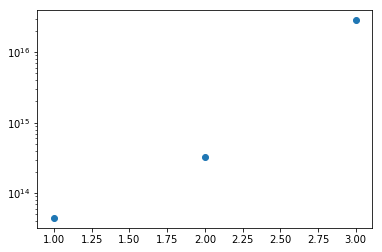

------------------------
l 2e-07
M1 49.37311751870227
M2_M3 43.191090437058016
M4 201.15533291536102
M5_M6 97.41683602415837
M7 879.2590595819955
M8 65.49125837103003
R1 363391.8965302636
C1 3e-13
------------------------
{'DeltaComCurrent': 26.213197731548316, 'PowerCom': 0.00021320442, 'RefCurrent': 5.11891e-05, 'RefPowerCom': 0.0001535673, 'DCGain_sim': 49.9882, 'PhaseMargin': 75.585, 'GB': 28870700.0, 'outR_sim': 84.18972778320312, 'outR': 40401.81716059905, 'DCGain': 59.58860017402702, 'CMRR': 60.9674, 'PSRR': 77.5022, 'VICM': 99.3555, 'VAMP': 1.480665, 'Out_V_Range': 59.546616666666665, 'SR': 11.0746, 'Noise': 0.0217395, 'Area': 1.886858493966666e-09}
{'section1_value': 422953360942062.94, 'section2_value': 105352533502357.89, 'section3_value': 5499.051758069368, 'section4_value': 216886.03928422442, 'eval1': -211476680471031.47, 'eval2': -52676266751178.945, 'eval3': -2749.525879034684, 'eval4': -108443.01964211221}
------------------------
l 2e-07
M1 82.06870292321744
M2_M3 56.

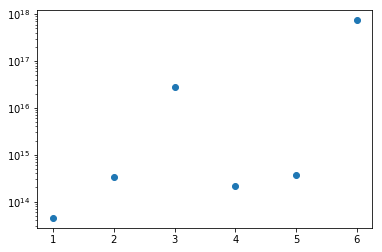

[False, False]
------------------------
l 2e-07
M1 37.76192070673562
M2_M3 88.04161038735796
M4 558.7404603448055
M5_M6 13.878003083762472
M7 349.9636426259965
M8 56.16654925145545
R1 774018.9247581088
C1 3e-13
------------------------
{'DeltaComCurrent': 27.96107137282848, 'PowerCom': 0.00026784219, 'RefCurrent': 6.34289e-05, 'RefPowerCom': 0.00019028669999999998, 'DCGain_sim': 52.2436, 'PhaseMargin': 76.587, 'GB': 17114800.0, 'outR_sim': 55.78329086303711, 'outR': 26923.400299077424, 'DCGain': 59.65078960044071, 'CMRR': 61.0829, 'PSRR': 79.771, 'VICM': 95.6495, 'VAMP': 1.369485, 'Out_V_Range': 63.164449999999995, 'SR': 5.24137, 'Noise': 0.0312887, 'Area': 3.141012103963945e-09}
{'section1_value': 156005813019665.38, 'section2_value': 42972694883845.05, 'section3_value': 2716.9105111191357, 'section4_value': 261115.7285510511, 'eval1': -78002906509832.69, 'eval2': -21486347441922.523, 'eval3': -1358.4552555595678, 'eval4': -130557.86427552556}
[False, False]
------------------------
l

KeyboardInterrupt: 

In [35]:
myBayseOpt = BayesianOptimization(f=B.opamp_f, domain=domain,
                          acquisition_type="LCB", kernel=kernel,
                          #constraints=constraints,
                          exact_feval=True)
for i in range(N):
    myBayseOpt.run_optimization(max_iter=1)
    print(breakCondition(myBayseOpt.Y, eps=eps))
    if all(breakCondition(myBayseOpt.Y, eps=eps)):
        break